# Header

In [33]:
import pandas as pd
import ezodf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import pandas_profiling as pp
import pycaret
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
from IPython.display import clear_output
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, Normalizer, 
    MaxAbsScaler, QuantileTransformer, PowerTransformer
)
from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans

In [34]:
seed = 17

# Read file

In [35]:
def read_ods(filename, sheet_no=0, header=0):
    tab = ezodf.opendoc(filename=filename).sheets[sheet_no]
    return pd.DataFrame({col[header].value:[x.value for x in col[header+1:]]
                        for col in tab.columns()})

In [36]:
tbtl = read_ods('./Data/label/tbtl-public.ods')
ck = pd.read_csv('./Data/ready_data/ready_ck.csv')
qt = pd.read_csv('./Data/ready_data/ready_qt.csv')

tbtl.TBTL = tbtl.TBTL.astype(float)

In [37]:
ck = ck[['username', 'CK']]
qt = qt[['username', 'diemqt']]

In [38]:
df = pd.read_csv('./Data/ready_data/ready_th.csv')

In [39]:
df.columns

Index(['username', 'count_submit', 'count_problem', 'avg_submit',
       'count_assignment', 'sum_pre_score', 'avg_pre_score', 'avg_coef',
       'time', 'ratio', 'point_hard', 'time_hard', 'avg_submit_hard', 'start',
       'max_problem', 'count_hard_problems', 'ratio_problem', 'hash', 'TH'],
      dtype='object')

In [40]:
df.drop(columns=['hash'], inplace=True)

In [41]:
df = pd.merge(df, ck, on='username', how='left')
df = pd.merge(df, qt, on='username', how='left')
df = pd.merge(df, tbtl, on='username', how='left')

In [42]:
df

,username,count_submit,count_problem,avg_submit,count_assignment,sum_pre_score,avg_pre_score,avg_coef,time,ratio,...,time_hard,avg_submit_hard,start,max_problem,count_hard_problems,ratio_problem,TH,CK,diemqt,TBTL
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,147,46,3.195652,7,460000,10000.000000,100.000000,2.0,6.571429,...,2.5,4.500000,0.285714,47.0,0.0,0.978723,5.0,5.5,7.5,7.24
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,259,78,3.320513,9,752499,9647.423077,100.000000,6.0,8.666667,...,14.5,3.416667,5.222222,96.0,0.0,0.812500,8.5,6.5,7.0,8.11
2,01122b3ef7e59b84189e65985305f575d6bdf83c,195,66,2.954545,7,615300,9322.727273,100.000000,6.0,9.428571,...,9.0,3.250000,0.714286,61.0,0.0,0.820896,7.0,4.5,9.0,7.30
3,013de369c439ab0ead8aa7da64423aa395a8be39,107,52,2.057692,8,465626,8954.346154,96.153846,9.0,6.500000,...,8.0,2.416667,2.500000,75.0,0.0,0.693333,10.0,5.0,10.0,8.20
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,199,90,2.211111,9,796000,8844.444444,100.000000,16.0,10.000000,...,16.0,2.500000,14.888889,103.0,0.0,0.873786,6.0,4.0,9.0,7.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,111,43,2.581395,6,414000,9627.906977,100.000000,12.0,7.166667,...,8.0,4.800000,8.166667,52.0,0.0,0.826923,6.0,5.5,9.0,7.67
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,357,104,3.432692,17,1031846,9921.596154,100.000000,22.0,6.117647,...,7.0,4.842105,22.852941,111.0,0.0,0.936937,8.5,6.0,8.0,7.54
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,155,52,2.980769,8,474000,9115.384615,100.000000,9.0,6.500000,...,7.0,6.000000,29.937500,67.0,0.0,0.776119,5.5,6.0,6.5,7.49
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,557,114,4.885965,12,1106000,9701.754386,100.000000,7.0,9.500000,...,7.0,6.904762,11.416667,121.0,0.0,0.942149,10.0,7.0,10.0,8.94


In [43]:
df.describe()

,count_submit,count_problem,avg_submit,count_assignment,sum_pre_score,avg_pre_score,avg_coef,time,ratio,point_hard,time_hard,avg_submit_hard,start,max_problem,count_hard_problems,ratio_problem,TH,CK,diemqt,TBTL
count,761.000000,761.000000,761.000000,761.000000,7.610000e+02,761.000000,761.000000,761.000000,761.000000,761.000000,761.00000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,206.320631,64.148489,3.158201,7.402102,6.083412e+05,9088.483807,99.620383,9.174770,9.048095,102963.584757,8.35611,4.013664,11.529350,80.358739,0.099869,0.772873,7.288845,5.477483,8.294430,7.855427
std,139.638018,33.006662,1.385422,3.743232,3.263871e+05,1652.383707,2.419928,5.104146,4.807622,57143.334816,3.73893,2.182504,13.191073,38.492840,0.774945,0.190525,2.168836,2.144337,1.737223,0.904670
min,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000,47.368421,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,3.000000,0.000000,0.100000,0.500000,0.000000,0.000000,2.520000
25%,112.000000,42.000000,2.266667,5.000000,3.745450e+05,9135.243902,100.000000,5.000000,6.076923,53846.000000,6.50000,2.611111,2.000000,53.000000,0.000000,0.691275,5.500000,4.000000,7.500000,7.330000
50%,191.000000,64.000000,2.906250,7.000000,6.137610e+05,9594.220000,100.000000,9.000000,7.818182,110000.000000,8.00000,3.666667,8.166667,83.000000,0.000000,0.819672,8.000000,5.500000,9.000000,7.930000
75%,280.000000,93.000000,3.756098,10.000000,8.920000e+05,9859.154930,100.000000,14.000000,11.600000,150000.000000,11.00000,5.000000,17.000000,112.000000,0.000000,0.910448,9.000000,7.000000,9.500000,8.540000
max,1019.000000,131.000000,12.500000,22.000000,1.284638e+06,10000.000000,100.000000,22.000000,30.000000,317774.000000,17.50000,17.600000,120.000000,165.000000,11.000000,1.000000,10.000000,10.000000,10.000000,9.610000


# TBTL

In [44]:
tbtl_df = df.copy()

In [45]:
def experiment(df, id='username', target='TBTL', dev=False, seed=17):
    df.dropna(inplace=True)
    results = []

    scalers = {
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler(),
        'Normalizer': Normalizer(),
        'MaxAbsScaler': MaxAbsScaler(),
        'QuantileTransformer': QuantileTransformer(),
        'PowerTransformer': PowerTransformer(method='yeo-johnson')
    }

    for scaler_name, scaler in scalers.items():
        df_scaled = df.copy()

        # Apply the scaler to all columns except the target and id
        if id in df_scaled.columns and target in df_scaled.columns:
            features = df_scaled.drop(columns=[id, target]).columns
        elif id in df_scaled.columns:
            features = df_scaled.drop(columns=[id]).columns
        elif target in df_scaled.columns:
            features = df_scaled.drop(columns=[target]).columns
        else:
            features = df_scaled.columns
        
        df_scaled[features] = scaler.fit_transform(df_scaled[features])
        df_scaled[target] = df[target]

        # Run the model training and evaluation
        s = setup(data=df_scaled.drop(columns=[id]), target=target, use_gpu=True, profile=False, session_id=seed)
        clear_output()
        best_model = compare_models(fold=5, sort='R2', verbose=False)
        result = pull()
        result = result[['Model', 'R2']]
        result = result[result['R2'] > 0.2]
        if dev:
            result = result.head(1)
        result['Scaler'] = scaler_name
        results.append(result)

    # Combine results from all scalers into a single DataFrame
    final_results = pd.concat(results, ignore_index=True)
    return final_results

In [46]:
tbtl_df.drop(columns=['TH', 'diemqt', 'CK'], inplace=True)

In [47]:
predict_th = pd.read_csv('./th_prediction.csv', header=None)
predict_qt = pd.read_csv('./qt_prediction.csv', header=None)
predict_ck = pd.read_csv('./ck_prediction.csv', header=None)

In [48]:
tbtl_df['TH'] = predict_th
tbtl_df['QT'] = predict_qt
tbtl_df['CK'] = predict_ck

## inital result

In [49]:
s = setup(data = tbtl_df.drop(columns=['username']), target = 'TBTL', use_gpu=True, profile=False, session_id=seed)
clear_output()
best_model = compare_models(fold=5, sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.5291,0.5169,0.7158,0.3632,0.0952,0.0759,0.0720
br,Bayesian Ridge,0.5281,0.5210,0.7195,0.3541,0.0957,0.0759,0.0080
ridge,Ridge Regression,0.5274,0.5195,0.7189,0.3540,0.0954,0.0756,0.0080
lr,Linear Regression,0.5278,0.5203,0.7194,0.3531,0.0955,0.0757,0.0080
catboost,CatBoost Regressor,0.5429,0.5463,0.7350,0.3293,0.0972,0.0778,5.4300
rf,Random Forest Regressor,0.5421,0.5455,0.7353,0.3291,0.0976,0.0779,0.1080
gbr,Gradient Boosting Regressor,0.5533,0.5623,0.7464,0.3063,0.0989,0.0796,0.1400
ada,AdaBoost Regressor,0.5661,0.5622,0.7476,0.3035,0.0987,0.0803,0.0620
lightgbm,Light Gradient Boosting Machine,0.5715,0.6203,0.7841,0.2364,0.1029,0.0816,0.6940
en,Elastic Net,0.6434,0.7394,0.8558,0.0908,0.1111,0.0923,0.0080


In [50]:
init_expe = experiment(tbtl_df, dev=True)
init_expe

,Model,R2,Scaler
0,Bayesian Ridge,0.3634,StandardScaler
1,Ridge Regression,0.3684,MinMaxScaler
2,Extra Trees Regressor,0.3632,RobustScaler
3,Gradient Boosting Regressor,0.2278,Normalizer
4,Ridge Regression,0.3672,MaxAbsScaler
5,Bayesian Ridge,0.3760,QuantileTransformer
6,Bayesian Ridge,0.3776,PowerTransformer


## EDA

In [51]:
def draw_scatter_plot(x, y, df=tbtl_df, x_threshold=None, y_threshold=None):
    def categorize_TH(tbtl):
        if tbtl < 5:
            return 'tbtl < 5'
        elif 5 <= tbtl < 6:
            return '5 <= tbtl < 6'
        elif 6 <= tbtl < 8:
            return '6 <= tbtl < 8'
        elif 8 <= tbtl < 9:
            return '8 <= tbtl < 9'
        elif 9 <= tbtl < 10:
            return '9 <= tbtl < 10'
        else:
            return 'Other'  # To handle TH values outside the specified ranges
        
    df['TBTL_category'] = df['TBTL'].apply(categorize_TH)
    sns.scatterplot(data=df, x=x, y=y, hue='TBTL_category', palette='tab10')
    if x_threshold is not None:
        plt.axvline(x=x_threshold, color='red', linestyle='--', linewidth=2)
    if y_threshold is not None:
        plt.axhline(y=y_threshold, color='red', linestyle='--', linewidth=2)

### point hard vs time

In [54]:
tbtl_df.TBTL_category.value_counts()

TBTL_category
6 <= tbtl < 8     387
8 <= tbtl < 9     308
9 <= tbtl < 10     53
5 <= tbtl < 6       8
tbtl < 5            5
Name: count, dtype: int64

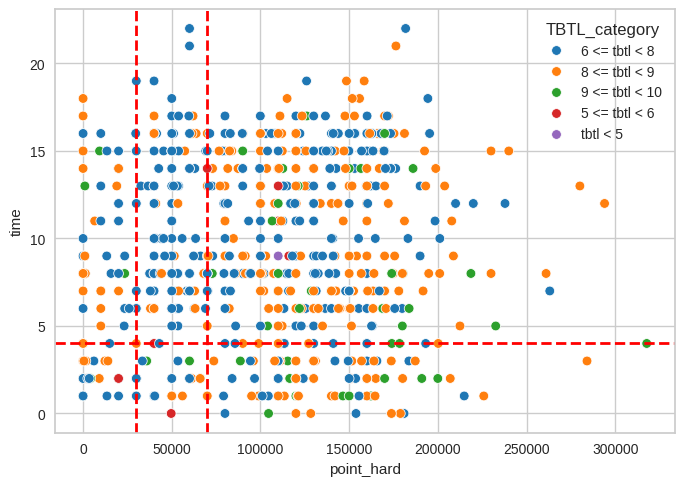

In [55]:
sns.scatterplot(x=tbtl_df.point_hard, y=tbtl_df.time, hue=tbtl_df.TBTL_category, palette='tab10')
plt.axvline(x=70_000, color='red', linestyle='--', linewidth=2)
plt.axvline(x=30_000, color='red', linestyle='--', linewidth=2)
plt.axhline(y=4, color='red', linestyle='--', linewidth=2)
plt.show()

### count problem vs avg submit

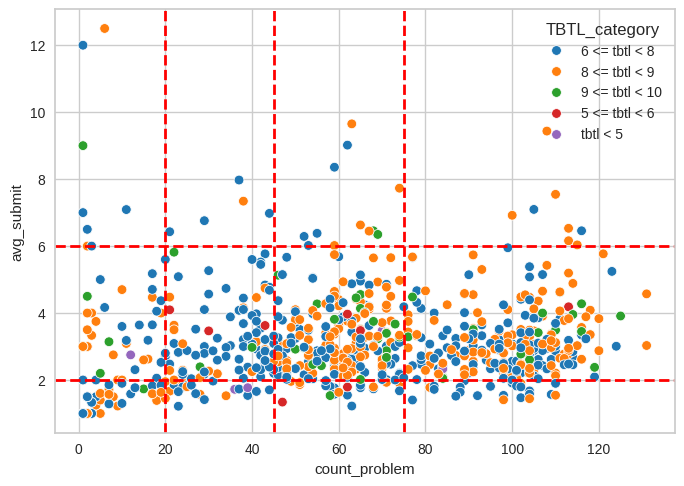

In [56]:
sns.scatterplot(x=tbtl_df.count_problem, y=tbtl_df.avg_submit, hue=tbtl_df.TBTL_category, palette='tab10')
plt.axvline(x=45, color='red', linestyle='--', linewidth=2)
plt.axvline(x=75, color='red', linestyle='--', linewidth=2)
plt.axvline(x=20, color='red', linestyle='--', linewidth=2)
plt.axhline(y=2, color='red', linestyle='--', linewidth=2)
plt.axhline(y=6, color='red', linestyle='--', linewidth=2)
plt.show()

### count_problem vs avg_coef

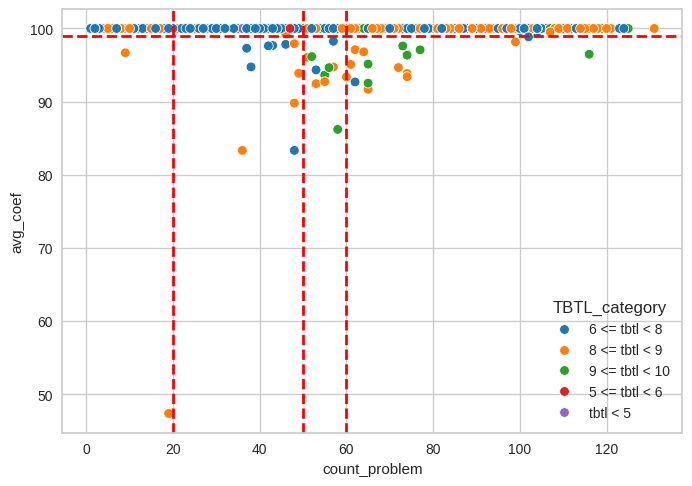

In [57]:
sns.scatterplot(x=tbtl_df.count_problem, y=tbtl_df.avg_coef, hue=tbtl_df.TBTL_category, palette='tab10')
plt.axvline(x=60, color='red', linestyle='--', linewidth=2)
plt.axvline(x=50, color='red', linestyle='--', linewidth=2)
plt.axvline(x=20, color='red', linestyle='--', linewidth=2)
plt.axhline(y=99, color='red', linestyle='--', linewidth=2)
plt.show()

### count hard problem

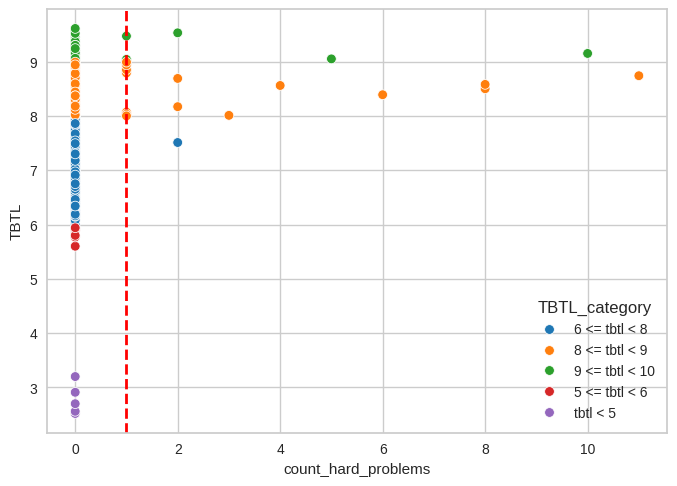

In [58]:
draw_scatter_plot('count_hard_problems', 'TBTL', x_threshold=1)

### point_hard/avg_submit vs count_submit

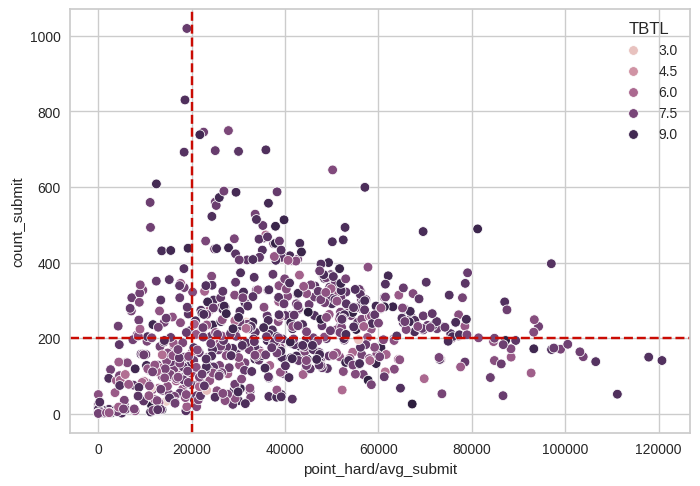

In [59]:
sns.scatterplot(x=tbtl_df.point_hard/tbtl_df.avg_submit, y=tbtl_df.count_submit, hue=tbtl_df.TBTL)
plt.xlabel('point_hard/avg_submit')
plt.axvline(x=20000, color='r', linestyle='--')
plt.axhline(y=200, color='r', linestyle='--')

### diem qt vs ck vs th

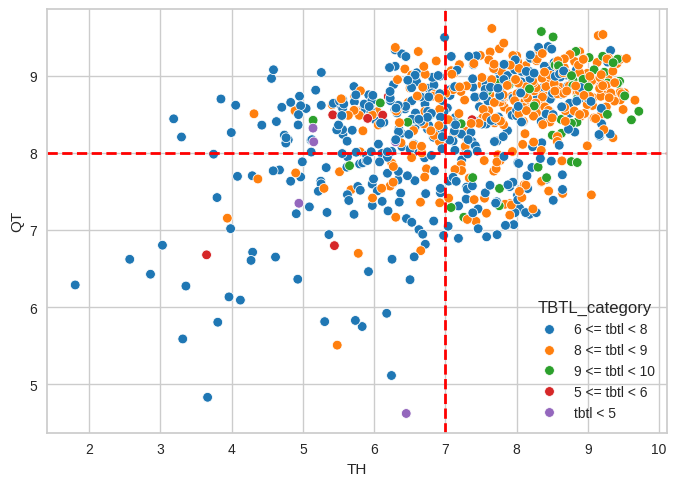

In [60]:
sns.scatterplot(x=tbtl_df.TH, y=tbtl_df.QT, hue=tbtl_df.TBTL_category, palette='tab10')
plt.axvline(x=7, color='red', linestyle='--', linewidth=2)
plt.axhline(y=8, color='red', linestyle='--', linewidth=2)

### ck vs th

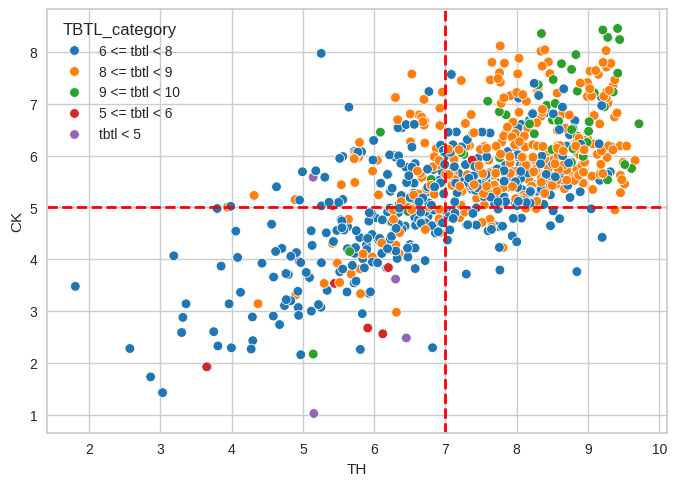

In [61]:
sns.scatterplot(x=tbtl_df.TH, y=tbtl_df.CK, hue=tbtl_df.TBTL_category, palette='tab10')
plt.axvline(x=7, color='red', linestyle='--', linewidth=2)
plt.axhline(y=5, color='red', linestyle='--', linewidth=2)

### diemqt vs ck

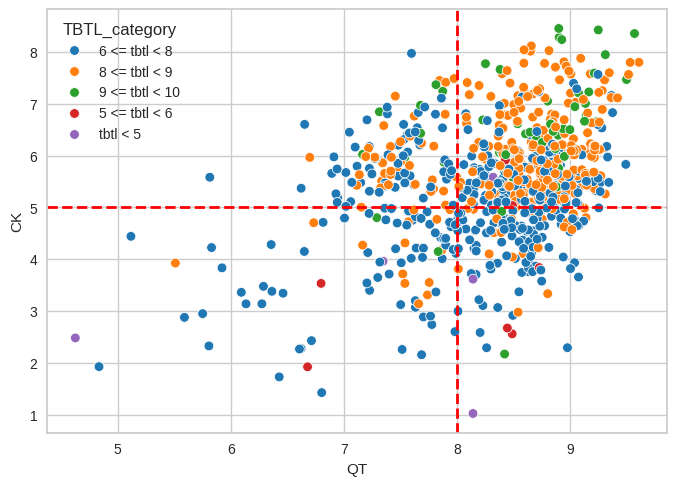

In [62]:
sns.scatterplot(x=tbtl_df.QT, y=tbtl_df.CK, hue=tbtl_df.TBTL_category, palette='tab10')
plt.axvline(x=8, color='red', linestyle='--', linewidth=2)
plt.axhline(y=5, color='red', linestyle='--', linewidth=2)

### ck vs diemqt/avg_submit

Text(0.5, 0, 'diemqt/avg_submit')

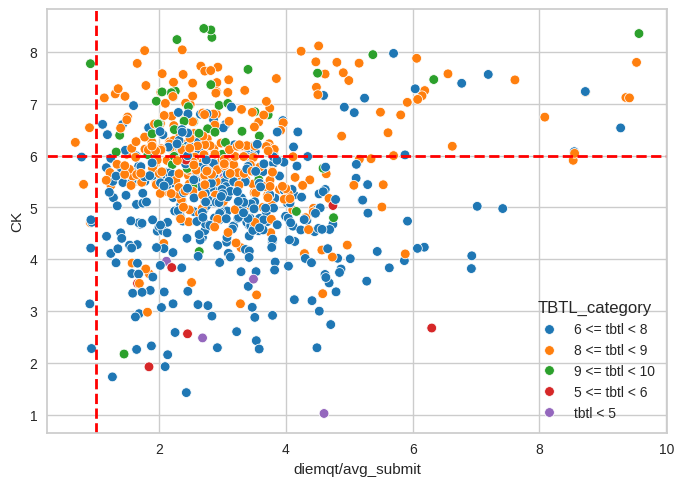

In [64]:
sns.scatterplot(x=tbtl_df.QT/tbtl_df.avg_submit, y=tbtl_df.CK, hue=tbtl_df.TBTL_category, palette='tab10')
plt.axvline(x=1, color='red', linestyle='--', linewidth=2)
plt.axhline(y=6, color='red', linestyle='--', linewidth=2)
plt.xlabel('diemqt/avg_submit')

### time vs diemqt

Text(0.5, 0, 'time')

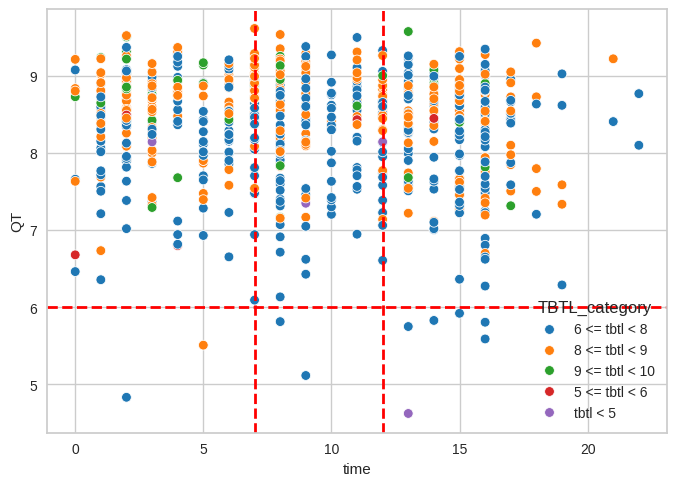

In [68]:
sns.scatterplot(x=tbtl_df.time, y=tbtl_df.QT, hue=tbtl_df.TBTL_category, palette='tab10')
plt.axvline(x=7, color='red', linestyle='--', linewidth=2)
plt.axvline(x=12, color='red', linestyle='--', linewidth=2)
plt.axhline(y=6, color='red', linestyle='--', linewidth=2)
plt.xlabel('time')

## Feature engineering

In [69]:
def tbtl_preprocess(df):
    df_copy = df.copy()
    
    df_copy['point_hard_vs_time'] = (df_copy['point_hard'] > 30_000) & (df_copy['time'] > 4) & (df_copy['point_hard'] < 70_000)
    
    conditions = [
        (df_copy['count_problem'] > 45) & (df_copy['count_problem'] < 75) & (df_copy['avg_submit'] > 2),
        (df_copy['count_problem'] < 45) & (df_copy['count_problem'] > 20) & (df_copy['avg_submit'] > 2)
    ]
    
    values = [2, 1]
    df_copy['count_problem_vs_avg_submit'] = np.select(conditions, values, default=0)
    
    conditions = [
        (df_copy.count_problem > 60) & (df_copy.avg_coef > 99),
        (df_copy.count_problem >= 20) & (df_copy.avg_coef > 99) & (df_copy.count_problem < 50),
    ]
    df_copy['count_problem_vs_avg_coef'] = np.select(conditions, values, default=0)
    
    df_copy['hard_problem'] = df_copy['count_hard_problems'] >= 1
    df_copy['point_hard/avg_submit_vs_count_submit'] = (df_copy['point_hard']/df_copy['avg_submit'] < 20000) & (df_copy['count_submit'] < 200)
    df_copy['diemqt_vs_th'] = (df_copy['TH'] > 7) & (df_copy['QT'] > 8)
    df_copy['ck_vs_th'] = (df_copy['TH'] > 7) & (df_copy['CK'] > 5)
    df_copy['ck_vs_diemqt'] = (df_copy['QT'] > 8) & (df_copy['CK'] > 5)
    df_copy['ck_vs_diemqt/avg_submit'] = (df_copy['QT']/df_copy['avg_submit'] > 1) & (df_copy['CK'] > 6)
    df_copy['time_vs_qt'] = (df_copy['time'] > 7) & (df_copy['QT'] > 6) & (df_copy['time'] < 12)
    return df_copy

In [70]:
if 'TBTL_category' in tbtl_df.columns:
    tbtl_df.drop(columns=['TBTL_category'], inplace=True)

In [71]:
train_df = tbtl_preprocess(tbtl_df)

In [72]:
len(tbtl_df.columns), len(train_df.columns)

(21, 31)

### second experiment

In [73]:
s = setup(data = train_df.drop(columns=['username']), target = 'TBTL', use_gpu=True, profile=False, session_id=seed)
clear_output()
best_model = compare_models(fold=5, sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.5217,0.5116,0.7124,0.3677,0.0950,0.0751,0.0680
ridge,Ridge Regression,0.5267,0.5206,0.7185,0.3570,0.0953,0.0755,0.0160
lr,Linear Regression,0.5287,0.5241,0.7208,0.3534,0.0955,0.0757,0.0180
rf,Random Forest Regressor,0.5374,0.5399,0.7310,0.3366,0.0971,0.0773,0.1260
catboost,CatBoost Regressor,0.5486,0.5577,0.7422,0.3168,0.0981,0.0787,5.6020
et,Extra Trees Regressor,0.5459,0.5594,0.7438,0.3147,0.0985,0.0782,0.0960
gbr,Gradient Boosting Regressor,0.5507,0.5587,0.7449,0.3071,0.0989,0.0792,0.1500
ada,AdaBoost Regressor,0.5644,0.5693,0.7521,0.2959,0.0992,0.0802,0.0740
lightgbm,Light Gradient Boosting Machine,0.5746,0.6245,0.7859,0.2329,0.1031,0.0821,2.7540
en,Elastic Net,0.6434,0.7394,0.8558,0.0908,0.1111,0.0923,0.0180


In [74]:
second_expe = experiment(train_df, dev=True)
second_expe

,Model,R2,Scaler
0,Bayesian Ridge,0.3814,StandardScaler
1,Ridge Regression,0.3791,MinMaxScaler
2,Bayesian Ridge,0.3782,RobustScaler
3,AdaBoost Regressor,0.2821,Normalizer
4,Ridge Regression,0.3793,MaxAbsScaler
5,Bayesian Ridge,0.3728,QuantileTransformer
6,Bayesian Ridge,0.3844,PowerTransformer


## Feature selection

In [75]:
selector = RFECV(estimator=CatBoostRegressor(random_seed=seed, verbose=False),
                 cv=5, scoring='r2', n_jobs=-1)

In [76]:
selector.fit(train_df.drop(columns=['TBTL', 'username']), train_df['TBTL'])

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7b96708a3be0>,
      n_jobs=-1, scoring='r2')

In [77]:
np.save('./Data/tbtl_selector.npy', selector.support_)

In [78]:
selector_support = np.load('./Data/tbtl_selector.npy')

In [79]:
selected_features = train_df.drop(columns=['TBTL', 'username']).columns[selector_support]

In [80]:
df_train = train_df[['username', 'TBTL'] + list(selected_features)]

## pipeline

### preprocessing

In [92]:
def tbtl_preprocessing(df_train, df_test):
    
    train = tbtl_preprocess(df_train)
    test = tbtl_preprocess(df_test)
    
    selector_support = np.load('./Data/tbtl_selector.npy')
    train = train[['username', 'TBTL'] + list(train.drop(columns=['TBTL', 'username']).columns[selector_support])]
    test = test[['username'] + list(test.drop(columns=['username']).columns[selector_support])]
    
    scaler = PowerTransformer(method='yeo-johnson')
    features = train.drop(columns=['username', 'TBTL']).columns
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])
    
    return train, test

In [93]:
test = pd.read_csv('./Data/work_data.csv')
test = test[~test.username.isin(tbtl_df.username)]

In [94]:
ck = pd.read_csv('./ck_submit.csv')
qt = pd.read_csv('./qt_submit.csv')
th = pd.read_csv('./th_submit.csv')

In [95]:
test.reset_index(drop=True, inplace=True)
ck.reset_index(drop=True, inplace=True)
qt.reset_index(drop=True, inplace=True)
th.reset_index(drop=True, inplace=True)

In [96]:
test['CK'] = ck['score']
test['QT'] = qt['score']
test['TH'] = th['score']

In [97]:
df_train, df_test = tbtl_preprocessing(tbtl_df, test)

## modelling

In [98]:
s = setup(data = df_train.drop(columns=['username']), target = 'TBTL', use_gpu=True, profile=False, session_id=seed)
clear_output()
top5 = compare_models(fold=5, sort='R2', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.5163,0.5005,0.7047,0.3825,0.0943,0.0745,0.0320
huber,Huber Regressor,0.5133,0.5111,0.7123,0.3691,0.0954,0.0746,0.0580
ridge,Ridge Regression,0.5218,0.5178,0.7170,0.3603,0.0956,0.0752,0.0080
lr,Linear Regression,0.5233,0.5263,0.7226,0.3506,0.0965,0.0754,0.0140
omp,Orthogonal Matching Pursuit,0.5413,0.5254,0.7229,0.3467,0.0956,0.0773,0.0100
rf,Random Forest Regressor,0.5400,0.5440,0.7338,0.3315,0.0974,0.0776,0.1260
catboost,CatBoost Regressor,0.5495,0.5507,0.7378,0.3242,0.0976,0.0788,5.6160
et,Extra Trees Regressor,0.5468,0.5569,0.7430,0.3142,0.0982,0.0781,0.0800
gbr,Gradient Boosting Regressor,0.5512,0.5621,0.7466,0.3044,0.0991,0.0794,0.1420
ada,AdaBoost Regressor,0.5698,0.5681,0.7516,0.2963,0.0990,0.0808,0.0680


### hypertune

In [99]:
tuned_top5 = [tune_model(model, fold=5, n_iter=100, 
                         optimize='MAE', search_library='optuna', choose_better=True) for model in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5113,0.5456,0.7387,0.3272,0.1051,0.0771
1,0.5256,0.5447,0.7380,0.3716,0.1006,0.0775
2,0.5068,0.5041,0.7100,0.3564,0.0953,0.0738
3,0.5657,0.5685,0.7540,0.4440,0.1037,0.0833
4,0.4721,0.3401,0.5831,0.4122,0.0667,0.0604
Mean,0.5163,0.5006,0.7048,0.3823,0.0943,0.0744
Std,0.0303,0.0829,0.0624,0.0413,0.0142,0.0077


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4936,0.5306,0.7284,0.3457,0.1045,0.0754
1,0.5123,0.5382,0.7336,0.3791,0.1005,0.0762
2,0.5050,0.5219,0.7224,0.3338,0.0964,0.0738
3,0.5729,0.5900,0.7681,0.4230,0.1056,0.0847
4,0.4793,0.3531,0.5942,0.3897,0.0679,0.0616
Mean,0.5126,0.5067,0.7093,0.3743,0.0950,0.0743
Std,0.0322,0.0804,0.0597,0.0319,0.0139,0.0074


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5073,0.5404,0.7351,0.3336,0.1047,0.0766
1,0.5261,0.5520,0.7429,0.3632,0.1010,0.0775
2,0.5142,0.5214,0.7221,0.3344,0.0964,0.0746
3,0.5671,0.5723,0.7565,0.4403,0.1038,0.0834
4,0.4790,0.3511,0.5925,0.3931,0.0677,0.0612
Mean,0.5187,0.5074,0.7098,0.3729,0.0947,0.0747
Std,0.0287,0.0799,0.0597,0.0402,0.0138,0.0073


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5109,0.5498,0.7415,0.3221,0.1056,0.0773
1,0.5366,0.5982,0.7735,0.3098,0.1054,0.0790
2,0.5146,0.5298,0.7279,0.3236,0.0970,0.0746
3,0.5715,0.5937,0.7705,0.4195,0.1059,0.0844
4,0.4827,0.3599,0.5999,0.3779,0.0686,0.0617
Mean,0.5233,0.5263,0.7226,0.3506,0.0965,0.0754
Std,0.0296,0.0871,0.0638,0.0417,0.0144,0.0076


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5043,0.5281,0.7267,0.3488,0.1033,0.0757
1,0.5221,0.5398,0.7347,0.3772,0.1000,0.0769
2,0.5223,0.5208,0.7216,0.3352,0.0959,0.0754
3,0.5490,0.5369,0.7327,0.4749,0.1004,0.0804
4,0.4858,0.3572,0.5976,0.3826,0.0684,0.0622
Mean,0.5167,0.4966,0.7027,0.3837,0.0936,0.0741
Std,0.0211,0.0700,0.0527,0.0489,0.0128,0.0062


In [102]:
blender = blend_models(estimator_list=tuned_top5, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5039,0.5369,0.7327,0.3380,0.1045,0.0762
1,0.5233,0.5483,0.7405,0.3674,0.1009,0.0773
2,0.5112,0.5165,0.7187,0.3406,0.0960,0.0743
3,0.5650,0.5694,0.7546,0.4432,0.1037,0.0832
4,0.4790,0.3487,0.5905,0.3972,0.0675,0.0613
Mean,0.5165,0.5040,0.7074,0.3773,0.0945,0.0745
Std,0.0283,0.0795,0.0596,0.0393,0.0138,0.0072


In [101]:
stacker = stack_models(estimator_list=tuned_top5, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5111,0.5366,0.7325,0.3384,0.1040,0.0767
1,0.5354,0.5645,0.7513,0.3487,0.1013,0.0787
2,0.5138,0.5058,0.7112,0.3542,0.0951,0.0745
3,0.5713,0.5752,0.7584,0.4375,0.1043,0.0841
4,0.4810,0.3490,0.5908,0.3967,0.0676,0.0615
Mean,0.5225,0.5062,0.7089,0.3751,0.0945,0.0751
Std,0.0299,0.0822,0.0613,0.0370,0.0138,0.0075


### save load model

In [104]:
save_model(stacker, './model/TBTL/stacker')
save_model(blender, './model/TBTL/blender')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['count_submit', 'count_problem',
                                              'avg_submit', 'count_assignment',
                                              'sum_pre_score', 'avg_pre_score',
                                              'avg_coef', 'time', 'ratio',
                                              'point_hard', 'time_hard',
                                              'avg_submit_hard', 'start',
                                              'max_problem', 'ratio_problem',
                                              'TH', 'QT', 'CK',
                                              'point_hard_vs_time',
                                              'count_problem_vs_...
                  VotingRegressor(estimators=[('Bayesian Ridge',
                                               BayesianRidge()),
                                              ('Hube

In [105]:
stacker = load_model('./model/TBTL/stacker')
blender = load_model('./model/TBTL/blender')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [106]:
from sklearn import set_config
set_config(display='diagram')
stacker

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['count_submit', 'count_problem',
                                             'avg_submit', 'count_assignment',
                                             'sum_pre_score', 'avg_pre_score',
                                             'avg_coef', 'time', 'ratio',
                                             'point_hard', 'time_hard',
                                             'avg_submit_hard', 'start',
                                             'max_problem', 'ratio_problem',
                                             'TH', 'QT', 'CK',
                                             'point_hard_vs_time',
                                             'count_...
                                                BayesianRidge()),
                                               ('Huber Regressor',
                                                HuberRegressor(alpha=0.9880819837043763,
                                                               epsilon=1.7657573161231592)),
                                               ('Ridge Regression',
                                                Ridge(alpha=9.999750637512015,
                                                      random_state=17)),
                                               ('Linear Regression',
                                                LinearRegression(n_jobs=-1)),
                                               ('Orthogonal Matching Pursuit',
                                                OrthogonalMatchingPursuit(n_nonzero_coefs=12))],
                                   final_estimator=LinearRegression(n_jobs=-1),
                                   n_jobs=1))])

In [107]:
blender

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['count_submit', 'count_problem',
                                             'avg_submit', 'count_assignment',
                                             'sum_pre_score', 'avg_pre_score',
                                             'avg_coef', 'time', 'ratio',
                                             'point_hard', 'time_hard',
                                             'avg_submit_hard', 'start',
                                             'max_problem', 'ratio_problem',
                                             'TH', 'QT', 'CK',
                                             'point_hard_vs_time',
                                             'count_...
                 VotingRegressor(estimators=[('Bayesian Ridge',
                                              BayesianRidge()),
                                             ('Huber Regressor',
                                              HuberRegressor(alpha=0.9880819837043763,
                                                             epsilon=1.7657573161231592)),
                                             ('Ridge Regression',
                                              Ridge(alpha=9.999750637512015,
                                                    random_state=17)),
                                             ('Linear Regression',
                                              LinearRegression(n_jobs=-1)),
                                             ('Orthogonal Matching Pursuit',
                                              OrthogonalMatchingPursuit(n_nonzero_coefs=12))],
                                 n_jobs=1))])

### predict

In [110]:
predict = predict_model(blender, data=df_test.drop(columns=['username']))

In [111]:
submit = pd.DataFrame({'username': test.username, 'TBTL': predict.prediction_label})
submit.to_csv('./tbtl_submit.csv', index=False, header=False)